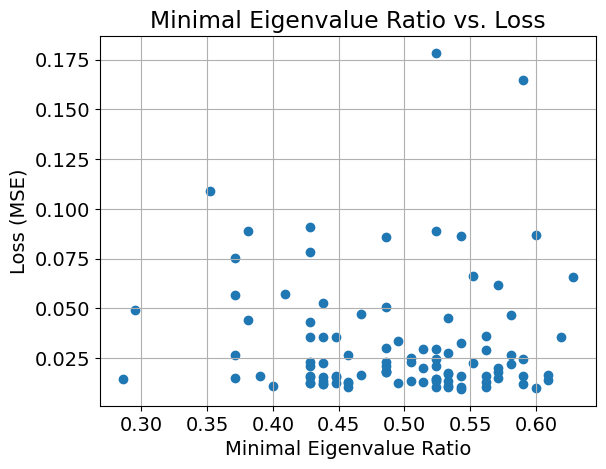

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import matplotlib.pyplot as plt
%matplotlib inline

# Generate random input data in range (-10, 10)
input_data = 20 * torch.rand((1000, 1)) - 10

# Compute ground truth
ground_truth = (torch.sin(5 * np.pi * input_data)) / (5 * np.pi * input_data)

# Function to calculate the number of trainable parameters in the model
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

# Neural Network
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.layer1 = nn.Linear(1, 10)  # First layer with 10 neurons
        self.layer2 = nn.Linear(10, 7)  # Second layer with 7 neurons
        self.output_layer = nn.Linear(7, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x = torch.tanh(self.layer1(x))  # first layer
        x = torch.relu(self.layer2(x))  # ReLU in the second layer
        x = self.output_layer(x)        # No activation in the output
        return x


net = CustomNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Function to calculate the minimum ratio of positive eigenvalues
def minimum_eigenvalue_ratio(eigenvalues):
    positive_count = torch.sum(eigenvalues > 0).item()
    total_count = eigenvalues.numel()
    return positive_count / total_count

# Function to calculate gradient norm for the model
def calculate_gradient_norm(model):
    grad_norms = []
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            grad_norm = layer.weight.grad.norm(2).item() if layer.weight.grad is not None else 0
            grad_norms.append(grad_norm)
    return np.mean(grad_norms) if grad_norms else 0

# Lists to store results
loss_history = []
min_eigen_ratios = []
gradient_norms = []  # List to store gradient norms
num_training_loops = 100  # Number of training cycles

# Training loop to minimize the MSE loss and calculate loss and eigenvalue ratios
for iteration in range(num_training_loops):
    epochs = 100  # Number of epochs per training cycle
    epoch_loss = 0

    net = CustomNN()  # Reinitialize the network for each training loop
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(input_data)
        loss = loss_fn(outputs, ground_truth)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Calculate and store the gradient norm
        grad_norm = calculate_gradient_norm(net)
        gradient_norms.append(grad_norm)


    # Average the loss over epochs
    loss_history.append(epoch_loss / epochs)

    # Calculate the number of parameters and allocate space for the Hessian matrix
    num_params = count_parameters(net)
    Hessian = torch.zeros((num_params, num_params))

    predicted = net(input_data)
    total_loss = ((predicted - input_data) ** 2).mean()  # Objective function: MSE

    # Calculate the Jacobian matrix
    jacobian = torch.autograd.grad(total_loss, list(net.parameters()), create_graph=True)
    jacobian = torch.cat([param.flatten() for param in jacobian])

    # Compute Hessian matrix
    for i in range(num_params):
        gradient = torch.autograd.grad(jacobian[i], list(net.parameters()), retain_graph=True)
        Hessian[i] = torch.cat([grad.flatten() for grad in gradient])

    # Compute eigenvalues of the Hessian matrix
    eigenvalues, _ = torch.linalg.eig(Hessian)

    # Extract the real part of the eigenvalues for further computation
    real_eigenvalues = eigenvalues.real

    # Calculate the ratio of positive eigenvalues
    min_eigen_ratio = minimum_eigenvalue_ratio(real_eigenvalues)
    min_eigen_ratios.append(min_eigen_ratio)

# Plot the minimal eigenvalue ratio vs. loss
plt.scatter(min_eigen_ratios, loss_history)
plt.xlabel("Minimal Eigenvalue Ratio")
plt.ylabel("Loss (MSE)")
plt.title("Minimal Eigenvalue Ratio vs. Loss")
plt.grid(True)
plt.show()

